In [372]:
import re
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

In [373]:
from sklearn.preprocessing import MinMaxScaler

In [374]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [419]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [375]:
query_dir = 'queries'

In [376]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [377]:
query_client = bigquery.Client()

In [378]:
request = queries['combined_analysis_data.sql']

In [379]:
data = query_client.query(request).to_dataframe()

In [380]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [ ]:
data['post_code'] = data.address.apply(get_postcode_from_address)

In [381]:
data['price_per_sq_m'] = data.price / data.primary_size

In [415]:
data['lat_bin'] = pd.cut(data['lat'], bins=15, precision=5)
data['lng_bin'] = pd.cut(data['lng'], bins=15, precision=5)

In [420]:
post_codes_no = pd.read_csv('post_codes_no.csv', dtype={'post_code': str}).set_index('post_code')

In [440]:
data['settlement_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_no, how='left', left_on='post_code', right_index=True)['municipality']

In [441]:
post_codes_osl = pd.read_csv('post_codes.csv', dtype={'post_code':str}).set_index('post_code', drop=True)

In [423]:
data['neighborhood_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_osl, how='left', left_on='post_code', right_index=True)['neighborhood_name']

In [445]:
data['area_name'] = [settlement if settlement != 'OSLO' else neighborhood
                     for settlement, neighborhood
                     in zip(data['settlement_name'], data['neighborhood_name'])]

In [446]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'OSLO' else False)

In [452]:
std = pd.pivot_table(data=data, index='address_oslo', values='price_per_sq_m', aggfunc='std')
mean = pd.pivot_table(data=data, index='address_oslo', values='price_per_sq_m', aggfunc='mean')

In [453]:
std / mean

,price_per_sq_m
address_oslo,
False,0.305440
True,0.282489


In [455]:
to_plot = data[data.address_oslo == True]
std = pd.pivot_table(data=to_plot, index='area_name', values='price_per_sq_m', aggfunc='std')
mean = pd.pivot_table(data=to_plot, index='area_name', values='price_per_sq_m', aggfunc='mean')

In [456]:
(std / mean).sort_values(by='price_per_sq_m')

,price_per_sq_m
area_name,
Sentrum,0.082523
Søndre Nordstrand,0.146695
Grünerløkka,0.160647
St.Hanshaugen,0.161513
Alna,0.164849
Nordstrand,0.189002
Sagene,0.189627
Østensjø,0.193687
Frogner,0.220810


In [457]:
pd.pivot_table(data=to_plot, index='area_name', values='price_per_sq_m', aggfunc='count')

,price_per_sq_m
area_name,
Alna,17
Bjerke,15
Frogner,64
Gamle Oslo,125
Grorud,14
Grünerløkka,135
Nordre Aker,37
Nordstrand,35
Sagene,81


In [387]:
scaler = MinMaxScaler()
data['price_per_sq_m_scaled'] = scaler.fit_transform(data['price_per_sq_m'].to_frame())

In [388]:
# data.set_index(['ad_id', 'apt_id'], drop=True)

In [389]:
data['construction_year_bin'] = pd.cut(data['construction_year'], bins=15, precision=0)

In [411]:
data['time_s_bin'] = pd.cut(data['construction_year'], bins=15, precision=0)

In [390]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,brokerage_expenses,common_wealth,common_debt,time_s,lat,lng,address,short_description,full_description,energy_letter,energy_color,price_per_sq_m,lat_bin,lng_bin,post_code,address_in_oslo,price_per_sq_m_scaled,construction_year_bin
0,85287718,120,True,2.0,1.0,48.0,59.0,4150000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,86458.333333,"(59.8827, 59.9973]","(10.73437, 10.85...",0663,True,0.462035,"(2008.0, 2019.0]"
1,85287718,143,True,2.0,2.0,56.0,61.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,77678.571429,"(59.8827, 59.9973]","(10.73437, 10.85...",0663,True,0.407650,"(2008.0, 2019.0]"
2,85287718,183,True,2.0,5.0,51.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,85294.117647,"(59.8827, 59.9973]","(10.73437, 10.85...",0663,True,0.454823,"(2008.0, 2019.0]"
3,85287718,187,True,2.0,5.0,48.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,90625.000000,"(59.8827, 59.9973]","(10.73437, 10.85...",0663,True,0.487844,"(2008.0, 2019.0]"
4,85287718,204,True,3.0,6.0,86.0,92.0,8495000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,98779.069767,"(59.8827, 59.9973]","(10.73437, 10.85...",0663,True,0.538354,"(2008.0, 2019.0]"


# Geographic Distribution

In [391]:
sample_size = 1400
to_plot = data[(data.lat.notnull()) & (data.price_per_sq_m.notnull())].sample(sample_size)

m = folium.Map([59.9116, 10.7545], zoom_start=11)
#mark each station as a point
for index, row in to_plot.iterrows():
    folium.CircleMarker([row['lat'], row['lng']],
                        radius=1,
                        popup=(row['lat'], row['lng']),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
#convert to (n, 2) nd-array format for heatmap
properties_array = to_plot[['lat', 'lng', 'price_per_sq_m_scaled']].values

#plot heatmap
m.add_child(plugins.HeatMap(properties_array, radius=15))
m

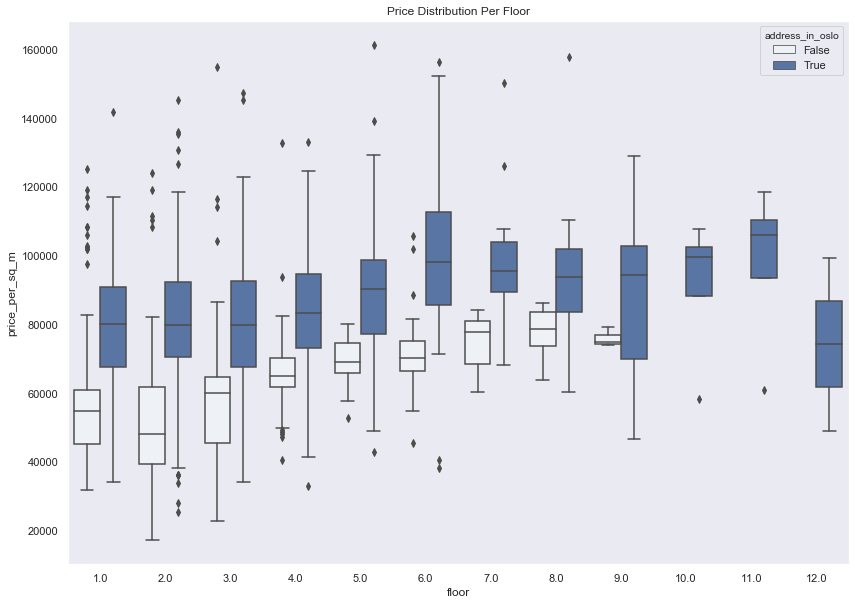

In [392]:
sns.boxplot(x='floor', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Floor')
plt.show()

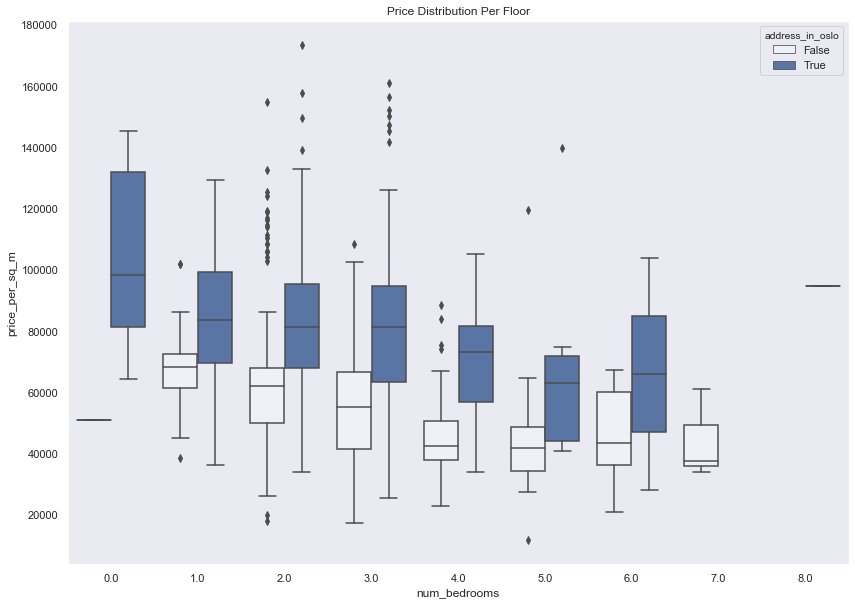

In [393]:
sns.boxplot(x='num_bedrooms', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Floor')
plt.show()

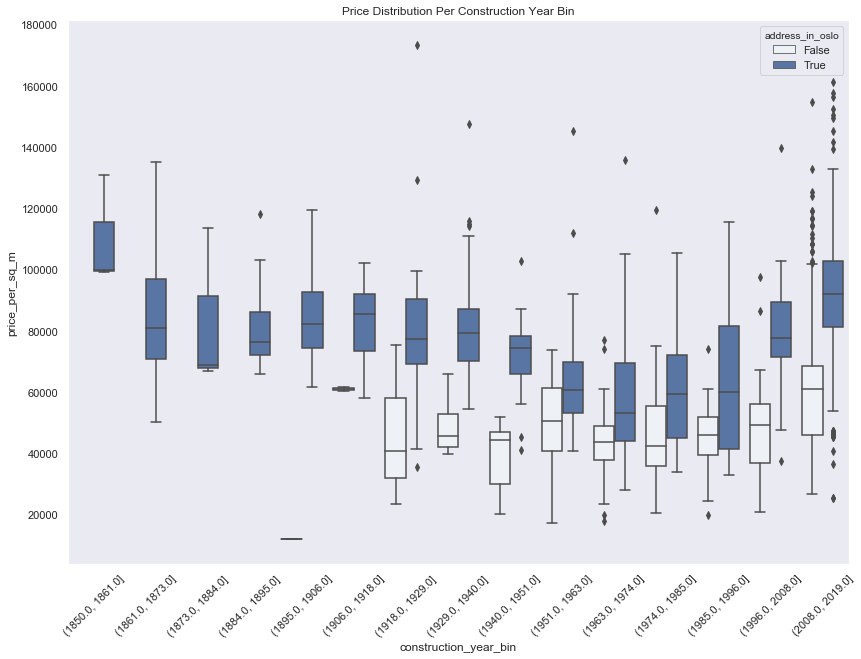

In [394]:
g = sns.boxplot(x='construction_year_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

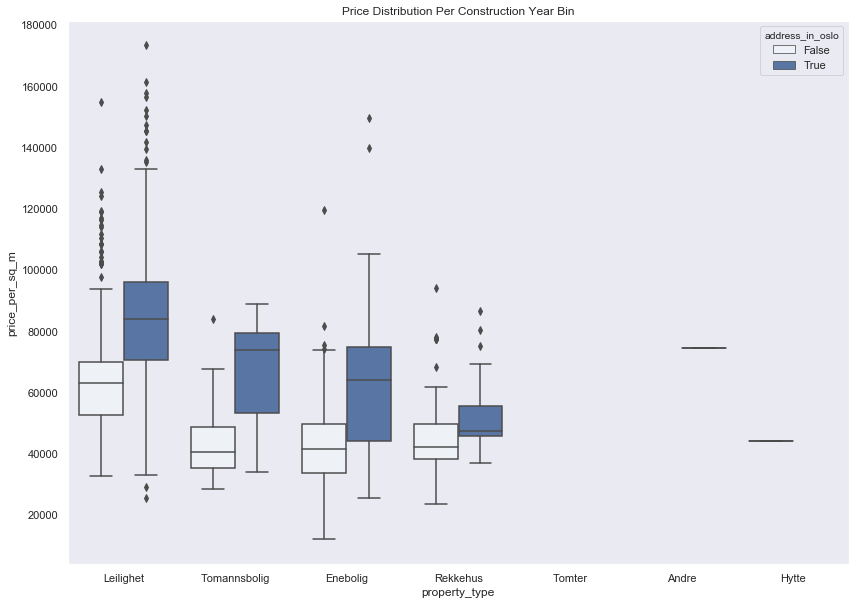

In [403]:
sns.boxplot(x='property_type', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

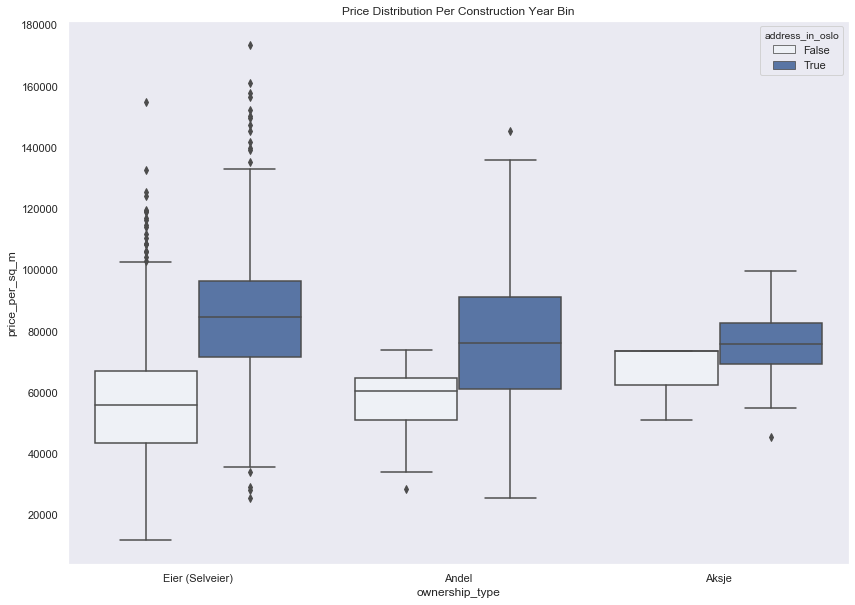

In [404]:
sns.boxplot(x='ownership_type', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

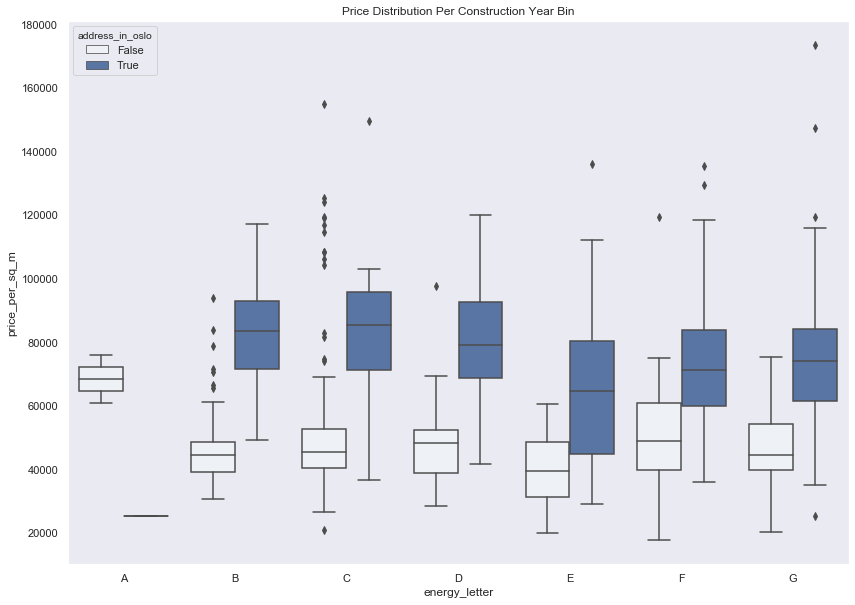

In [405]:
sns.boxplot(x='energy_letter', y='price_per_sq_m', hue='address_in_oslo', data=data.sort_values('energy_letter'), color='b')
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

In [398]:
to_plot = data
energy_mapping = {'mørkegrønn': 1, 'lysegrønn': 2, 'gul': 3, 'oransje': 4, 'rød': 5}
to_plot['energy_color'] = to_plot['energy_color'].map(energy_mapping)

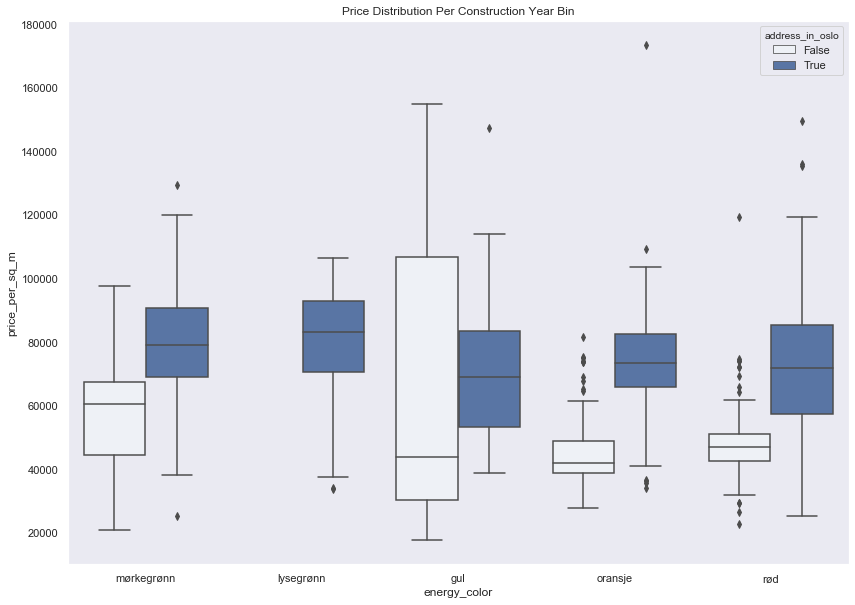

In [406]:
g = sns.boxplot(x='energy_color', y='price_per_sq_m', hue='address_in_oslo', data=to_plot.sort_values('energy_color'), color='b')
g.set_xticklabels(energy_mapping.keys())
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

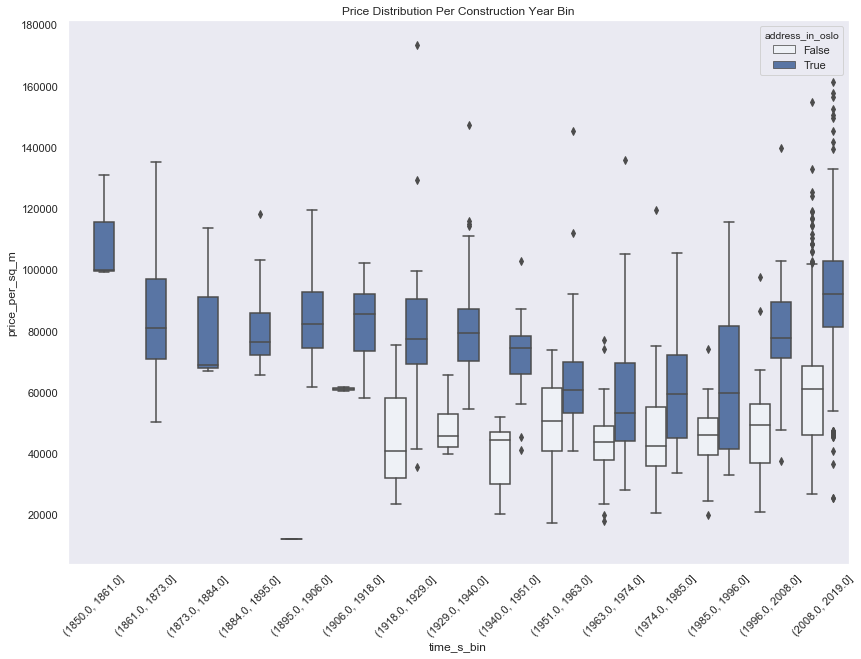

In [412]:
g = sns.boxplot(x='time_s_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

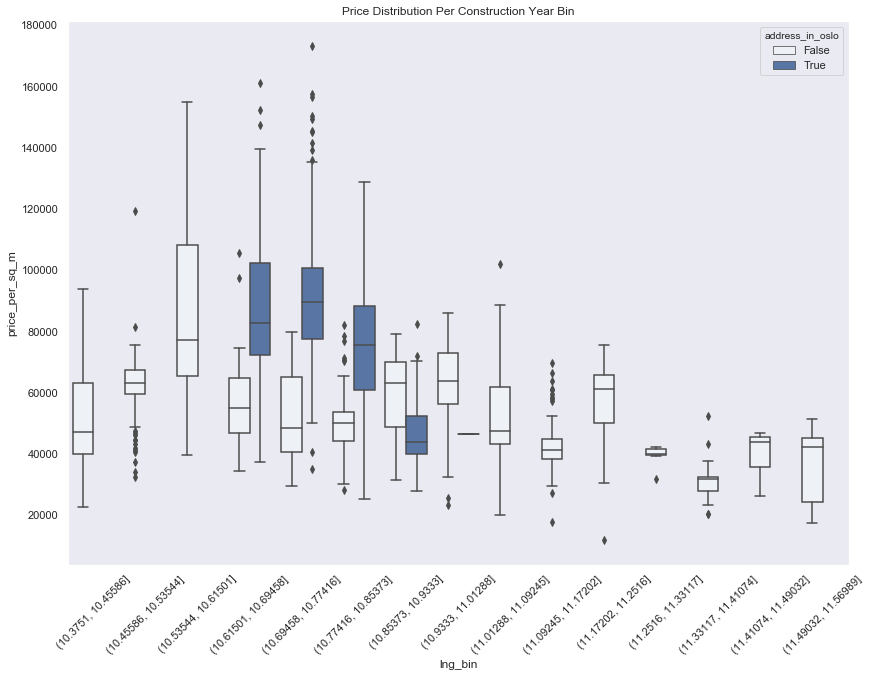

In [417]:
g = sns.boxplot(x='lng_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()

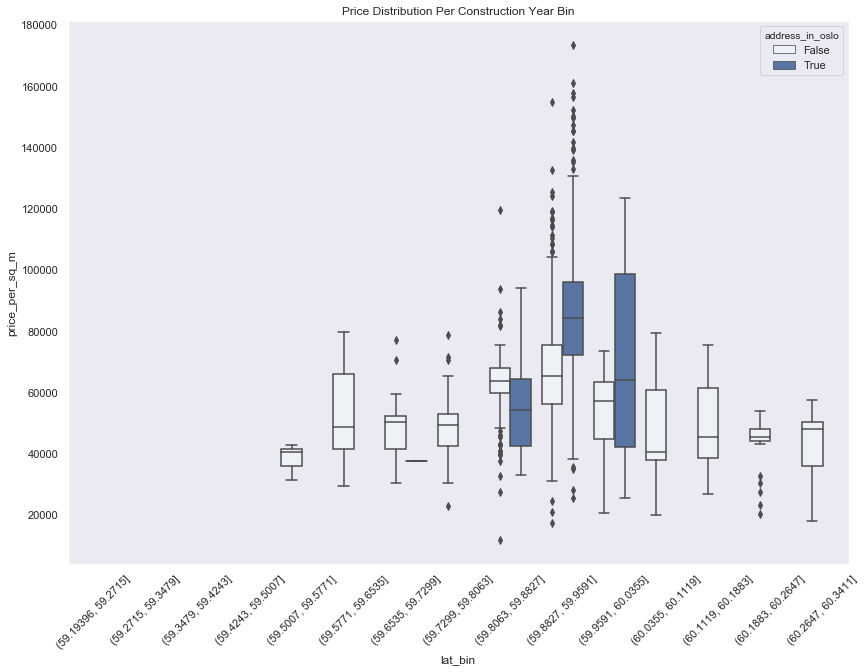

In [418]:
g = sns.boxplot(x='lat_bin', y='price_per_sq_m', hue='address_in_oslo', data=data, color='b')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Price Distribution Per Construction Year Bin')
plt.show()